In [1]:
import gensim
word2vec = gensim.models.Word2Vec.load_word2vec_format(
                                                       '/home/geoffrey_link/GoogleNews-vectors-negative300.bin', 
                                                       binary = True
                                                      )

In [2]:
import nltk
import numpy as np
import pandas as pd

questionpairs_train = pd.read_csv('/home/geoffrey_link/train.csv')

questionpairs_train_labels    = []
questionpairs_train_vectors   = np.zeros((questionpairs_train.shape[0], 300))

questionpairs_train_list      = []

for i in range(questionpairs_train.shape[0]):

    for word in nltk.word_tokenize(str(questionpairs_train['question1'].iloc[i]).decode('utf-8')):
        try:
            questionpairs_train_list.append(word2vec[word])
        except:
            continue

    for word in nltk.word_tokenize(str(questionpairs_train['question2'].iloc[i]).decode('utf-8')):
        try:
            questionpairs_train_list.append(word2vec[word])
        except:
            continue
            
    questionpairs_train_labels.append(questionpairs_train['is_duplicate'].iloc[i])
    questionpairs_train_vectors[i] = np.array(questionpairs_train_list).sum(axis=0)
    questionpairs_train_list       = []

# save memory
del questionpairs_train
del questionpairs_train_list

In [3]:
import xgboost as xgb

num_rounds           = 2
training_data_labels = xgb.DMatrix (
                                    data  = questionpairs_train_vectors, 
                                    label = questionpairs_train_labels
                                   )
param                = {
                        'max_depth' : 2, 
                        'eta'       : 1, 
                        'silent'    : 1, 
                        'objective' : 'binary:logistic'
                       }
bst                  = xgb.train (
                                  param,
                                  training_data_labels,
                                  num_rounds
                                 )

# save memory
del questionpairs_train_labels
del questionpairs_train_vectors

In [4]:
import nltk
import numpy as np
import pandas as pd

questionpairs_test  = pd.read_csv('/home/geoffrey_link/test.csv')

questionpairs_test_vectors   = np.zeros((questionpairs_test.shape[0], 300))

questionpairs_test_list      = []

for i in range(questionpairs_test.shape[0]):

    for word in nltk.word_tokenize(str(questionpairs_test['question1'].iloc[i]).decode('utf-8')):
        try:
            questionpairs_test_list.append(word2vec[word])
        except:
            continue

    for word in nltk.word_tokenize(str(questionpairs_test['question2'].iloc[i]).decode('utf-8')):
        try:
            questionpairs_test_list.append(word2vec[word])
        except:
            continue
            
    questionpairs_test_vectors[i] = np.array(questionpairs_test_list).sum(axis=0)
    questionpairs_test_list       = []

# save memory
del questionpairs_test_list
del word2vec

In [5]:
import pandas as pd
import xgboost as xgb

testing_data                      = xgb.DMatrix(questionpairs_test_vectors)

# save memory
del questionpairs_test_vectors

prediction_data                   = bst.predict(testing_data)
prediction_output                 = pd.DataFrame()
prediction_output['test_id']      = questionpairs_test['test_id']

# save memory
del questionpairs_test

prediction_output['is_duplicate'] = prediction_data
prediction_output.to_csv('simpleXGBoost_submission.csv', index=False)

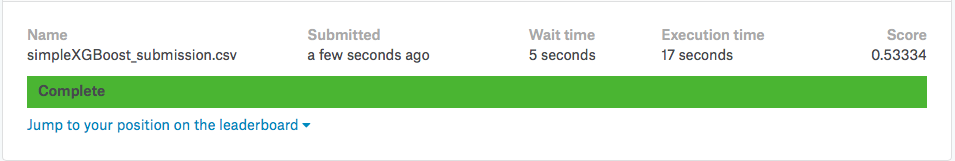

In [6]:
from IPython.display import Image
Image(filename='simpleXGBoost_submission.png')